<h1 style="font-family:Times New Roman;"> <center><b>ML Prediction on Student's Adaptability Level in Online Education </b></center> </h1>



<a id="1"></a>
> <h1 style = 'font-family: Times New Roman'><b> 1. Import Necessary Libraries </b></h1>

In [1]:
!pip install catboost


In [2]:
!pip install optuna


In [3]:
# (1) Data
import numpy as np
import pandas as pd

# (2) Visualization
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# (3) Preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# (4) Modeling Libraries

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# (5) Cluster Libraries
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score
# from yellowbrick.cluster import KElbowVisualizer

# (6) Tuning Libraries
import optuna

# (7) Metrics & Scoring Libraries
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# (8) Options
%matplotlib inline
from termcolor import colored
plt.rcParams['axes.unicode_minus'] = False
pd.reset_option('display.float_format')
pd.set_option('display.max_columns', None)

color_scheme = px.colors.qualitative.Pastel

In [4]:
!pip install scikit-learn==1.3.2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<mark>color scheme<mark>:

![image.png](attachment:9f3be24b-9402-4396-a2e2-1107a6a815a5.png)

<h3 style = 'font-family: Times New Roman'>Define <b>visualization functions</b> (bar, pie plot) below:</h3>

In [6]:
'''
Define bar plot using Plotly
'''
def p_bar_plot(x, y, x_axis_title, y_axis_title, title):
    fig = px.bar(x = x, y = y, color = x, text = y, color_discrete_sequence = color_scheme, template = 'simple_white')
    fig.update_layout(xaxis_title = x_axis_title, yaxis_title= y_axis_title, title = title, font = dict(size=17,family="Franklin Gothic"))
    fig.update_traces(width=0.5)
    fig.show()

'''
Define pie plot using Plotly
'''
def p_pie_plot(series, title):
    fig = px.pie(values=series.values, names=series.index, color_discrete_sequence=color_scheme,title= title, template='simple_white')
    fig.update_traces(textinfo='label+percent+value', textfont_size=20,
                  marker=dict(line=dict(color='#100000', width=0.2)))
    fig.data[0].marker.line.width = 1
    fig.update_layout(font=dict(size=20,family="Franklin Gothic"))
    fig.show()

<h3 style = 'font-family: Times New Roman'> Read .csv file: </h3>

In [7]:
df = pd.read_csv("/content/drive/MyDrive/students_adaptability_level_online_education.csv")

print(colored('Shape of DataFrame: ','blue'), df.shape, '\n\n')
df.head()

Shape of DataFrame:  (1205, 14) 




,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


<h4 style = 'font-family: Times New Roman'> As shown above, all columns are composed of categorical data.<br></h4>

***

<a id="2"></a>

> <h1 style = 'font-family: Times New Roman'><b>  2. Explore Data Analysis </b></h1>

<a id="2.1"></a>
> <h2 style = 'font-family: Times New Roman'><b> Univariate Analysis </b></h2>

In [8]:
series_1 = []
series_1_title = ['Gender', 'Institution Type']
series_1.append(df['Gender'].value_counts())
series_1.append(df['Institution Type'].value_counts())

fig = make_subplots(rows=1, cols= 2, specs =[[{"type": "pie"},{"type":"pie"}]])
for idx, series in enumerate(series_1):
    fig.add_trace(go.Pie(values = series.values,
                        labels = series.index,
                        marker = dict(colors = color_scheme),
                        title = str(idx+1)+'. '+series_1_title[idx]),
                        row = 1,
                        col = idx + 1)
    fig.update_traces(textinfo='label+percent+value', textfont_size=13,
    marker=dict(line=dict(color='#100000', width=0.2)))
fig.show()

<div class = 'alert alert-block alert-info'>
<h3 style='font-family: Times New Roman'>
    <div style='color:black'>💡 Male and Female seperately accounts for 55% and 45%;<br><br>
    Non Government type accounts for 68.3%</div>
</h3>

<h3 style = 'font-family: Times New Roman'><b> <b style='color:rgb(229, 134, 6)'>3. </b><u>Age</u>  & <b style='color:rgb(229, 134, 6)'>4. </b><u>Class Duration</u> </b></h3>

In [9]:
age = df['Age'].value_counts().sort_index()
class_duration = df['Class Duration'].value_counts().sort_index()
p_bar_plot(age.index, age.values, 'Age', 'Count', '3. Age Distribution')
p_bar_plot(class_duration.index, class_duration.values, 'Class Duration', 'Count', '4. Class Duration')

<div class = 'alert alert-block alert-info'>
<h3 style='font-family: Times New Roman'>
    <div style='color:black'>💡 Age of the respondents is mainly distributed between 11 and 25;<br><br>
    Class Duration mainly distributed between 1-3 hours</div>
</h3>
</div>

<h3 style = 'font-family: Times New Roman'><b> <b style='color:rgb(229, 134, 6)'>5. </b><u>Education Level</u>  & <b style='color:rgb(229, 134, 6)'>6. </b><u>Financial Condition</u>
    <b style='color:rgb(229, 134, 6)'>7. </b><u>Network Type</u></b></h3>

<cite> 5. <mark>Education Level</mark>: Education institution level </cite><br><br>
<cite> 6. <mark>Financial Condition</mark>: Financial condition of family </cite><br><br>
<cite> 7. <mark>Network Type</mark>:  Network connectivity type</cite>

In [10]:
series_2 = []
series_2_title = ['Education Level', 'Financial Condition', 'Network Type']
series_2.append(df['Education Level'].value_counts())
series_2.append(df['Financial Condition'].value_counts())
series_2.append(df['Network Type'].value_counts())

fig = make_subplots(rows=1, cols= 3, specs =[[{"type": "pie"},{"type":"pie"},{"type":"pie"}]])
for idx, series in enumerate(series_2):
    fig.add_trace(go.Pie(values = series.values,
                        labels = series.index,
                        marker = dict(colors = color_scheme),
                        title = str(idx+5)+'. '+series_2_title[idx]),
                        row = 1,
                        col = idx + 1)
    fig.update_traces(textinfo='label+percent+value', textfont_size=13,
    marker=dict(line=dict(color='#100000', width=0.2)))
fig.show()

<div class = 'alert alert-block alert-info'>
<h3 style='font-family: Times New Roman'>
    <div style = 'color:black'>💡 Most of the respondents attend Scool and University <br><br>
    And most of them are situated in Mid financial condition <br><br>
        There are just 1.58% of students using 2G network</div>
</h3>
</div>

<h3 style = 'font-family: Times New Roman'><b> <b style='color:rgb(229, 134, 6)'>8. </b><u>IT Student</u>  & <b style='color:rgb(229, 134, 6)'>9. </b><u>Location</u>
    <b style='color:rgb(229, 134, 6)'>10. </b><u>Self Lms</u></b></h3>

<cite> 8. <mark>IT Student</mark>: Studying as IT student or not </cite><br><br>
<cite> 9. <mark>Location</mark>: Is student located in town </cite><br><br>
<cite> 10. <mark>Self Lms</mark>:   Institution’s own LMS availability (Learning Management System)</cite>

In [11]:
series_3 = []
series_3_title = ['IT Student', 'Location', 'Self Lms']
series_3.append(df['IT Student'].value_counts())
series_3.append(df['Location'].value_counts())
series_3.append(df['Self Lms'].value_counts())

fig = make_subplots(rows=1, cols= 3, specs =[[{"type": "pie"},{"type":"pie"},{"type":"pie"}]])
for idx, series in enumerate(series_3):
    fig.add_trace(go.Pie(values = series.values,
                        labels = series.index,
                        marker = dict(colors = color_scheme),
                        title = str(idx+8)+'. '+series_3_title[idx]),
                        row = 1,
                        col = idx + 1)
    fig.update_traces(textinfo='label+percent+value', textfont_size=13,
    marker=dict(line=dict(color='#100000', width=0.2)))
fig.show()

<div class = 'alert alert-block alert-info'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
    💡 About 25.2% of respondents are studying as IT student<br><br>
    And 77.6% of them are located in town<br><br>
    Furthermore, 17.4% of their institutions own LMS availability</div>
</h3>

<h3 style = 'font-family: Times New Roman'><b> <b style='color:rgb(229, 134, 6)'>11. </b><u>Load-shedding</u>  & <b style='color:rgb(229, 134, 6)'>12. </b><u>Internet Type</u>
    <b style='color:rgb(229, 134, 6)'>13. </b><u>Device</u></b></h3>

<cite> 11. <mark>Load-shedding</mark>: Level of load shedding </cite><br><br>
<cite> 12. <mark>Internet Type</mark>: Internet type used mostly in device </cite><br><br>
<cite> 13. <mark>Device</mark>:  Device used mostly in class</cite>

In [12]:
series_4 = []
series_4_title = ['Load-shedding', 'Internet Type', 'Device']
series_4.append(df['Load-shedding'].value_counts())
series_4.append(df['Internet Type'].value_counts())
series_4.append(df['Device'].value_counts())

fig = make_subplots(rows=1, cols= 3, specs =[[{"type": "pie"},{"type":"pie"},{"type":"pie"}]])
for idx, series in enumerate(series_4):
    fig.add_trace(go.Pie(values = series.values,
                        labels = series.index,
                        marker = dict(colors = color_scheme),
                        title = str(idx+11)+'. '+series_4_title[idx]),
                        row = 1,
                        col = idx + 1)
    fig.update_traces(textinfo='label+percent+value', textfont_size=13,
    marker=dict(line=dict(color='#100000', width=0.2)))
fig.show()

<div class = 'alert alert-block alert-info'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
    💡 Load-shedding refers to level of load shedding, and type 'low' accounts for 83.3%<br><br>
    57.7% of respondents use mobile data to take online education<br><br>
    Furthermore, 84.1% of them use mobile to take online class
</div>
</h3>

<h3 style = 'font-family: Times New Roman'><b style='color:rgb(229, 134, 6)'>14. </b><u>Adaptivity Level (Target Column)</u> </h3>

<cite> 14. <mark>Adaptivity Level (Target Column)</mark>: Adaptability level of the student </cite>

In [13]:
p_pie_plot(df['Adaptivity Level'].value_counts(), '14. Adaptivity Level (Target Column)')

<div class = 'alert alert-block alert-info'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
    💡 Adaptability level which is our target column refers to adaptability level of the student during online education.<br><br>
    It can be seen that about 51.9% respond they have moderate adaptability, while low accounts for 39.8%, and high the rest.
</div></h3>

<a id="2.2"></a>
> <h2 style = 'font-family: Times New Roman'><b> 2.2. Multivariate Analysis </b></h2>

<a id="2.2.1"></a>
>> <h3 style = 'font-family: Times New Roman'><b>2.2.1. Age Distribution by Gender</b></h3>

In [14]:
gender_age = df.groupby(['Gender','Age']).size()
fig = go.Figure(data=[
    go.Bar(name='Boy', x=gender_age['Boy'].index, y=gender_age['Boy'].values,
           text=gender_age['Boy'].values, marker_color=color_scheme[0]),

    go.Bar(name='Girl', x=gender_age['Girl'].index, y=gender_age['Girl'].values,
           text=gender_age['Girl'].values, marker_color=color_scheme[1])
])
fig.update_layout(barmode='group', xaxis_tickangle=-45,title='Age Distribution by Gender',
                  template = 'simple_white')

fig.show()

<div class = 'alert alert-block alert-warning'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
💡 Female's age mainly ditributed in 11-20 while age of male mostly distributed between 11-15 and 21-25</div>
    </h3>
</div>

<a id="2.2.2"></a>
>> <h3 style = 'font-family: Times New Roman'><b>2.2.2. IT Student Distribution by Gender</b></h3>

In [15]:
gender_IT = df.groupby(['Gender','IT Student']).size()
fig = go.Figure(data=[
    go.Bar(name='Boy', x=gender_IT['Boy'].index, y=gender_IT['Boy'].values,
           text=gender_IT['Boy'].values, marker_color=color_scheme[0]),

    go.Bar(name='Girl', x=gender_IT['Girl'].index, y=gender_IT['Girl'].values,
           text=gender_IT['Girl'].values, marker_color=color_scheme[1])
])
fig.update_layout(barmode='group', xaxis_tickangle=-45,title='Distribution of IT Students by Gender',
                  template = 'simple_white')

fig.update_traces(width=0.3)

fig.show()

<div class = 'alert alert-block alert-warning'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
💡 We can notcie that male tend to study as IT student compared to female in the survey</div>
    </h3>
</div>

<a id="2.2.3"></a>
>> <h3 style = 'font-family: Times New Roman'><b>2.2.3. IT Student Distribution by Education</b></h3>

In [16]:
Education_IT = df.groupby(['Education Level','IT Student']).size()
fig = go.Figure(data=[
    go.Bar(name='College', x=Education_IT['College'].index, y=Education_IT['College'].values,
           text=Education_IT['College'].values, marker_color=color_scheme[0]),

    go.Bar(name='School', x=Education_IT['School'].index, y=Education_IT['School'].values,
           text=Education_IT['School'].values, marker_color=color_scheme[1]),

    go.Bar(name='University', x=Education_IT['University'].index, y=Education_IT['University'].values,
           text=Education_IT['University'].values, marker_color=color_scheme[2])
])
fig.update_layout(barmode='group', xaxis_tickangle=-45,title='Distribution of IT Students by Edu',
                  template = 'simple_white')

fig.update_traces(width=0.2)

fig.show()

<div class = 'alert alert-block alert-warning'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
💡 It is obvious that university got the most IT students, whereas 30 and 27 IT students in college and school.</div>
    </h3>
</div>

<a id="2.2.4"></a>
>> <h3 style = 'font-family: Times New Roman'><b>2.2.4. Gender Distribution by Adaptivity Level</b></h3>

In [17]:
Gender_Adaptivity = df.groupby(['Gender','Adaptivity Level']).size()
fig = go.Figure(data=[
    go.Bar(name='Boy', x=Gender_Adaptivity['Boy'].index, y=Gender_Adaptivity['Boy'].values,
           text=Gender_Adaptivity['Boy'].values, marker_color=color_scheme[0]),

    go.Bar(name='Girl', x=Gender_Adaptivity['Girl'].index, y=Gender_Adaptivity['Girl'].values,
           text=Gender_Adaptivity['Girl'].values, marker_color=color_scheme[1]),
])
fig.update_layout(barmode='group', xaxis_tickangle=-45,title='Distribution of Gender by Adaptivity Level',
                  template = 'simple_white')

fig.update_traces(width=0.3)

fig.show()

<div class = 'alert alert-block alert-warning'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
💡 In the survey, 71 male respondents answered as they have high adaptivity level in online education compared to 29 female.<br><br>
    Additionally, both male and female overall got moderate adativity level.</div>
    </h3>
</div>

<a id="2.2.5"></a>
>> <h3 style = 'font-family: Times New Roman'><b>2.2.5. Age Distribution by Adaptivity Level</b></h3>

In [18]:
Age_Adaptivity = df.groupby(['Age','Adaptivity Level']).size()
fig = go.Figure(data=[
    go.Bar(name='1-5', x=Age_Adaptivity['1-5'].index, y=Age_Adaptivity['1-5'].values,
           text=Age_Adaptivity['1-5'].values, marker_color=color_scheme[0]),

    go.Bar(name='6-10', x=Age_Adaptivity['6-10'].index, y=Age_Adaptivity['6-10'].values,
           text=Age_Adaptivity['6-10'].values, marker_color=color_scheme[1]),

    go.Bar(name='11-15', x=Age_Adaptivity['11-15'].index, y=Age_Adaptivity['11-15'].values,
           text=Age_Adaptivity['11-15'].values, marker_color=color_scheme[2]),

    go.Bar(name='16-20', x=Age_Adaptivity['16-20'].index, y=Age_Adaptivity['16-20'].values,
           text=Age_Adaptivity['16-20'].values, marker_color=color_scheme[3]),

    go.Bar(name='21-25', x=Age_Adaptivity['21-25'].index, y=Age_Adaptivity['21-25'].values,
           text=Age_Adaptivity['21-25'].values, marker_color=color_scheme[4]),

    go.Bar(name='26-30', x=Age_Adaptivity['26-30'].index, y=Age_Adaptivity['26-30'].values,
           text=Age_Adaptivity['26-30'].values, marker_color=color_scheme[5]),
])
fig.update_layout(barmode='group', xaxis_tickangle=-45,title='Distribution of Age by Adaptivity Level',
                  template = 'simple_white')

fig.update_traces(width=0.1)

fig.show()

<div class = 'alert alert-block alert-warning'>
<h3 style='font-family: Times New Roman'><div style = 'color:black'>
💡 11-15, 21-25 and 26-30 relatively got high adaptivity level while obvious that none of 1-5 got high adataptivity</div>
    </h3>
</div>

***

<a id="3"></a>
> <h1 style = 'font-family: Times New Roman'><b>  3. Preprocessing </b></h1>

<h3 style = 'font-family: Times New Roman'> Get columns' name of dataframe </h3>

In [19]:
# df.columns.tolist()
'''
features:
['Gender','Age','Education Level','Institution Type','IT Student','Location',
 'Load-shedding','Financial Condition','Internet Type','Network Type','Class Duration','Self Lms','Device','Adaptivity Level']
'''
columns = ['Gender','Age','Education Level','Institution Type','IT Student','Location',
           'Load-shedding','Financial Condition','Internet Type','Network Type',
           'Class Duration','Self Lms','Device','Adaptivity Level']

<a id="3.1"></a>
> <h2 style = 'font-family: Times New Roman'><b> 3.1. Encoding</b></h2>

<h3 style = 'font-family: Times New Roman'> Since data are composed of categorical values, use LabelEncoder() to encode into numeric values </h3>

In [20]:
for column in columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [21]:
df.head(4)

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,0,3,2,1,0,1,1,0,1,2,2,0,2,2
1,1,3,2,1,0,1,0,0,0,2,1,1,1,2
2,1,2,0,0,0,1,1,0,1,2,1,0,1,2
3,1,1,1,1,0,1,1,0,0,2,1,0,1,2


<a id="3.2"></a>
> <h2 style = 'font-family: Times New Roman'><b> 3.2. Train Test Split</b></h2>

<h3 style = 'font-family: Times New Roman'> Split dataframe into train and test set </h3>

In [22]:
y = df['Adaptivity Level']
X = df.drop('Adaptivity Level', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 116)

In [23]:
print(colored('Shape of X_train: ','blue'), X_train.shape, '\n\n')

print(colored('Shape of X_test: ', 'red'), X_test.shape)

Shape of X_train:  (843, 13) 


Shape of X_test:  (362, 13)


***

<a id="4"></a>
> <h1 style = 'font-family: Times New Roman'><b>  4. Modeling </b></h1>

<a id="4.1"></a>
> <h2 style = 'font-family: Times New Roman'><b> 4.1. Define Preprocessing & Modeling functions </b></h2>

In [24]:
class CONFIG:
    FOLD = 5               # Cross Validation Fold Num
    RANDOM_STATE = 116     # Random State
    # 4 models
    CLASSIFIERS = {
    "LogisiticRegression": LogisticRegression(max_iter = 1000,
                                              random_state = RANDOM_STATE),
    "KNearest": KNeighborsClassifier(),

    "RandomForestClassifier": RandomForestClassifier(random_state = RANDOM_STATE),

    "XGBClassifier": XGBClassifier(random_state = RANDOM_STATE),

    "CatBoostClassifier": CatBoostClassifier(random_state = RANDOM_STATE,
                                             logging_level='Silent')
    }
    # Features

    FEATURES = ['Gender','Age','Education Level','Institution Type','IT Student','Location',
           'Load-shedding','Financial Condition','Internet Type','Network Type',
           'Class Duration','Self Lms','Device']

    # CatBoost Best Parameters (using optuna)
    CB_BEST_PARAMS = {'iterations': 815, 'depth': 5,
                 'learning_rate': 0.08616774389778385,
                 'random_strength': 45, 'bagging_temperature': 0.23946457882908667,
                 'od_type': 'Iter', 'od_wait': 18,
                 'logging_level': 'Silent',
                 'random_state': RANDOM_STATE}

    # XGBoost Best Parameters (using optuna)
    XGB_BEST_PARAMS = {'n_estimators': 634, 'max_depth': 15,
                  'reg_alpha': 0, 'reg_lambda': 3,
                  'min_child_weight': 0, 'gamma': 0,
                  'learning_rate': 0.2616305059064822,
                  'colsample_bytree': 0.65,
                  'random_state': RANDOM_STATE}

In [25]:
# scaler function
def _scale(train_data, val_data, features):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_data[features])
    scaled_val = scaler.transform(val_data[features])

    train = train_data.copy()
    val = val_data.copy()

    train[features] = scaled_train
    val[features] = scaled_val

    return train, val

In [26]:
def classifiers_modeling(classifiers, X_train, y_train_, X_test, y_test, features):
    accuracy_list = []
    classifiers_name = list(classifiers.keys())
    # 5 Fold
    fold = KFold(n_splits = CONFIG.FOLD, random_state = CONFIG.RANDOM_STATE, shuffle=True)
    for idx, classifier in enumerate(classifiers.values()):
        accuracy = 0
        for fold_idx, (train_idx, val_idx) in enumerate(fold.split(X_train, y_train_)):
            x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train, y_val = y_train_.iloc[train_idx], y_train_.iloc[val_idx]
            x_train, x_val = _scale(x_train, x_val, features)
            model = classifier.fit(x_train[features], y_train)
            val_preds = model.predict(x_val[features])
            accuracy += accuracy_score(y_val, val_preds) / CONFIG.FOLD
        accuracy_list.append(round(accuracy,5))

        print('(',idx+1,')', classifiers_name[idx], 'cross validation (5 fold)')
        print('Mean Accurcy Score: ', round(accuracy, 5))
#         print('Mean Accuracy Score: ', colored(round(accuracy,5)))
    return accuracy_list

In [27]:
# Model Score Visualization
def p_bar_plot(x, y, width, x_axis_title, y_axis_title, title):
    fig = px.bar(x = x,
                 y = y,
                 color = x,
                 text = y,
                 color_discrete_sequence = color_scheme,
                 template = 'simple_white')

    fig.update_layout(xaxis_title = x_axis_title,
                      yaxis_title= y_axis_title,
                      title = title,
                      font = dict(size=17,family="Franklin Gothic"))

    fig.update_traces(width=width)

    fig.show()

<a id="4.2"></a>
> <h2 style = 'font-family: Times New Roman'><b>  4.2. Model Comparison (Part 1) </b></h2>

In [28]:
classifiers_name = list(CONFIG.CLASSIFIERS.keys())
classifiers_accuracy = []

In [29]:
classifiers_accuracy = classifiers_modeling(CONFIG.CLASSIFIERS, X_train, y_train, X_test, y_test, CONFIG.FEATURES)

( 1 ) LogisiticRegression cross validation (5 fold)
Mean Accurcy Score:  0.68809
( 2 ) KNearest cross validation (5 fold)
Mean Accurcy Score:  0.77112
( 3 ) RandomForestClassifier cross validation (5 fold)
Mean Accurcy Score:  0.89568
( 4 ) XGBClassifier cross validation (5 fold)
Mean Accurcy Score:  0.89094
( 5 ) CatBoostClassifier cross validation (5 fold)
Mean Accurcy Score:  0.88619


In [30]:
p_bar_plot(x = classifiers_name,
           y = np.round(classifiers_accuracy,3),
           width = 0.5,
           x_axis_title = 'Classifiers',
           y_axis_title = 'Classifiers Accuracy Score',
           title = 'Classifiers Accuracy Score (Cross Validated: 5 fold)'
               )

<h3 style = 'font-family: Times New Roman'> We can see that RandomForestClassifier, XGBClassifier and CatBoostClassifier got higest accuracy,<br><br> i've chosen XGBClassifier and CatBoostClassifier to get optimum hyperparameters using optuna</h3>

<a id="4.3"></a>
> <h2 style = 'font-family: Times New Roman'><b>  4.3. Hyperparameter Tuning </b></h2>

<a id="4.3.1"></a>
>> <h3 style = 'font-family: Times New Roman'><b> 4.3.1. CatBoost Classifier Hyperparameter Tuning </b></h3>

In [31]:
# Assuming you have imported or defined X_train and y_train
y_train_ = y_train


In [33]:
def cb_objective(trial):
     # CB Classifier Params
     params = {
         'iterations' : trial.suggest_int('iterations', 50, 1000),
         'depth' : trial.suggest_int('depth', 4, 10),
         'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
         'random_strength' :trial.suggest_int('random_strength', 0, 100),
         'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
         'od_wait' :trial.suggest_int('od_wait', 10, 50),
         'logging_level': 'Silent',
         'random_state': CONFIG.RANDOM_STATE
     }
     # Set Accuracy to zero
     accuracy = 0
     # Create Model
     cb_model = CatBoostClassifier(**params)
     # 5 Fold
     fold = KFold(n_splits = CONFIG.FOLD, random_state = CONFIG.RANDOM_STATE, shuffle=True)
     for fold_idx, (train_idx, val_idx) in enumerate(fold.split(X_train, y_train_)):
         x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
         x_train, x_val = _scale(x_train, x_val, CONFIG.FEATURES)
         y_train, y_val = y_train_.iloc[train_idx], y_train_.iloc[val_idx]
         model = cb_model.fit(x_train[CONFIG.FEATURES], y_train)
         val_preds = model.predict(x_val[CONFIG.FEATURES])

         accuracy += accuracy_score(y_val, val_preds) / CONFIG.FOLD
     # return /5 fold accuracy score
     return accuracy

cb_study = optuna.create_study(direction="maximize")
cb_study.optimize(cb_objective, n_trials=50, timeout=600)

[I 2023-12-12 16:08:28,517] A new study created in memory with name: no-name-74bdb15e-2689-45ae-8077-8e208f815300
<ipython-input-33-6a7d67160444>:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-33-6a7d67160444>:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2023-12-12 16:08:36,131] Trial 0 finished with value: 0.8779022259791491 and parameters: {'iterations': 154, 'depth': 9, 'learning_rate': 0.09721869686173583, 'random_strength': 52, 'bagging_temperature': 16.268047785164406, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 0 with value: 0.8779022259791491.
<ipython-input-33-6a7d67160444>:6: FutureWarning:

suggest_loguniform has been deprecat

* Best Parameters:  <br><br>
{'iterations': 815, 'depth': 5, 'learning_rate': 0.08616774389778385, 'random_strength': 45, 'bagging_temperature': 0.23946457882908667, 'od_type': 'Iter', 'od_wait': 18}

<a id="4.3.2"></a>
>> <h3 style = 'font-family: Times New Roman'><b> 4.3.2. XGBClassifier Hyperparameter Tuning </b></h3>

In [34]:
import os
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/students_adaptability_level_online_education.csv'


In [35]:
# File: Times.py

class Times:
    def __init__(self):
        pass

    def multiply(self, value):
        return value * 5


In [36]:


# Create an instance of the Times class
times_instance = Times()

# Use the multiply method
result = times_instance.multiply(5)
print(result)


25


In [37]:


result = Times()

# Make sure X_train and CONFIG are defined before using them
# ...

y_train_ = y_train

def xgb_objective(trial):
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 0, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'gamma': trial.suggest_int('gamma', 0, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01),
        'nthread': -1
    }

    # Get Accuracy
    accuracy = 0

    # Create Model
    xgb_model = XGBClassifier(**param)

    # 5 Fold
    fold = KFold(n_splits=CONFIG.FOLD, random_state=CONFIG.RANDOM_STATE, shuffle=True)

    for fold_idx, (train_idx, val_idx) in enumerate(fold.split(X_train, y_train_)):
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        x_train, x_val = _scale(x_train, x_val, CONFIG.FEATURES)
        y_train, y_val = y_train_.iloc[train_idx], y_train_.iloc[val_idx]
        model = xgb_model.fit(x_train[CONFIG.FEATURES], y_train)
        val_preds = model.predict(x_val[CONFIG.FEATURES])

        accuracy += accuracy_score(y_val, val_preds) / CONFIG.FOLD

    return accuracy

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=120, timeout=600)


[I 2023-12-12 16:18:37,174] A new study created in memory with name: no-name-9dcc9977-e367-4a9c-b094-6f655910e23d
<ipython-input-37-a805875558bd>:16: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-37-a805875558bd>:17: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.

[I 2023-12-12 16:18:41,182] Trial 0 finished with value: 0.7248520710059171 and parameters: {'n_estimators': 459, 'max_depth': 11, 'reg_alpha': 1, 'reg_lambda': 5, 'min_child_weight': 3, 'gamma': 2, 'learning_rate': 0.023662331355540283, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7248520710059171.
<ipython-input-37-a805875558bd>:16: FutureWarning:

suggest_loguniform has been de

* XGBClassifier Best Parameters: <br><br>

{'n_estimators': 806, 'max_depth': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1, 'gamma': 1, 'learning_rate': 0.2482733698361993, 'colsample_bytree': 0.5}

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import optuna

# Assuming you have a CONFIG object defined with necessary configurations
# You may need to replace CONFIG with your actual configuration object

# Define the Objective Function (xgb_objective)
def xgb_objective(trial):
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 0, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'gamma': trial.suggest_int('gamma', 0, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01),
        'nthread': -1
    }

    # Get Accuracy
    accuracy = 0

    # Create Model
    xgb_model = XGBClassifier(**param)

    # 5 Fold Cross-Validation
    fold = KFold(n_splits=CONFIG.FOLD, random_state=CONFIG.RANDOM_STATE, shuffle=True)
    for fold_idx, (train_idx, val_idx) in enumerate(fold.split(X_train, y_train_)):
        x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        x_train, x_val = _scale(x_train, x_val, CONFIG.FEATURES)
        y_train, y_val = y_train_.iloc[train_idx], y_train_.iloc[val_idx]

        model = xgb_model.fit(x_train[CONFIG.FEATURES], y_train)
        val_preds = model.predict(x_val[CONFIG.FEATURES])

        accuracy += accuracy_score(y_val, val_preds) / CONFIG.FOLD

    return accuracy

# Create an Optuna Study (xgb_study)
xgb_study = optuna.create_study(direction="maximize")

# Run Optimization (xgb_study.optimize)
xgb_study.optimize(xgb_objective, n_trials=120, timeout=600)

# Retrieve the best hyperparameters and their corresponding accuracy
best_params = xgb_study.best_params
best_accuracy = xgb_study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)


[I 2023-12-12 16:27:30,486] A new study created in memory with name: no-name-3a8ceb54-a5cf-4339-96ed-2d4f9e66fc4d
<ipython-input-38-4a67b336d3a9>:18: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-38-4a67b336d3a9>:19: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.

[I 2023-12-12 16:27:31,717] Trial 0 finished with value: 0.7663003663003664 and parameters: {'n_estimators': 439, 'max_depth': 4, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 0, 'gamma': 0, 'learning_rate': 0.15024012382350788, 'colsample_bytree': 0.37}. Best is trial 0 with value: 0.7663003663003664.
<ipython-input-38-4a67b336d3a9>:18: FutureWarning:

suggest_loguniform has been dep

Best Hyperparameters: {'n_estimators': 300, 'max_depth': 22, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 5, 'gamma': 0, 'learning_rate': 0.3345596173332975, 'colsample_bytree': 0.69}
Best Accuracy: 0.8873837700760778


<a id="4.4"></a>
> <h2 style = 'font-family: Times New Roman'><b>  4.4. Model Comparison (part 2) </b></h2>

In [39]:
tuned_classifiers = {
    "CatBoostClassifier": CatBoostClassifier(**CONFIG.CB_BEST_PARAMS),
    "XGBClassifier": XGBClassifier(**CONFIG.XGB_BEST_PARAMS)
}

In [40]:
classifiers_name.append('Tuned_CatBoostClassifier')
classifiers_name.append('Tuned_XGBClassifier')
tuned_accuracy = classifiers_modeling(tuned_classifiers, X_train, y_train, X_test, y_test, CONFIG.FEATURES)

for tuned_accuracy_score in tuned_accuracy:
    classifiers_accuracy.append(tuned_accuracy_score)

( 1 ) CatBoostClassifier cross validation (5 fold)
Mean Accurcy Score:  0.89806
( 2 ) XGBClassifier cross validation (5 fold)
Mean Accurcy Score:  0.89567


In [41]:
p_bar_plot(x = classifiers_name,
           y = np.round(classifiers_accuracy,3),
           width = 0.6,
           x_axis_title = 'Classifiers',
           y_axis_title = 'Classifiers Accuracy',
           title = 'Comparison of each Classifiers Accuracy Score (Fold=5, Tuned Model Added) ')

<h3 style = 'font-family: Times New Roman'> Accuracy has improved about 1% compared to before! </h3>

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

# Evaluate the Model
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
classification_report = classification_report(y_test, predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)

# Save Results
results = {
    'predictions': predictions,
    'accuracy': accuracy,
    'classification_report': classification_report,
}


Accuracy: 0.9060773480662984
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.54      0.68        28
           1       0.88      0.95      0.92       142
           2       0.92      0.93      0.92       192

    accuracy                           0.91       362
   macro avg       0.91      0.80      0.84       362
weighted avg       0.91      0.91      0.90       362



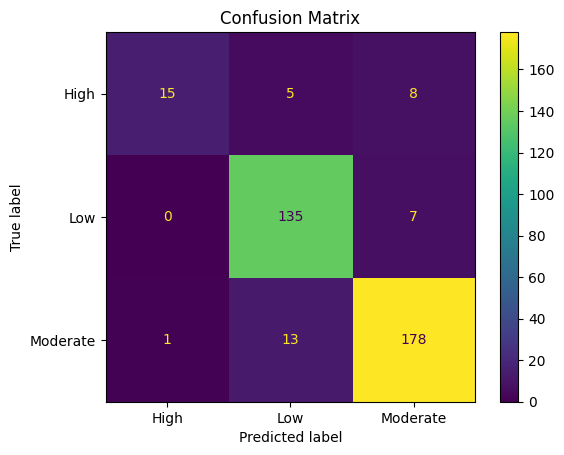

In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=["High", "Low", "Moderate"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()


               Variable  Variable Importance
10       Class Duration             0.172963
7   Financial Condition             0.116497
1                   Age             0.112784
0                Gender             0.084702
9          Network Type             0.067345
3      Institution Type             0.066702
2       Education Level             0.064999
5              Location             0.059916
8         Internet Type             0.056194
11             Self Lms             0.053408
12               Device             0.050199
6         Load-shedding             0.047519
4            IT Student             0.046773


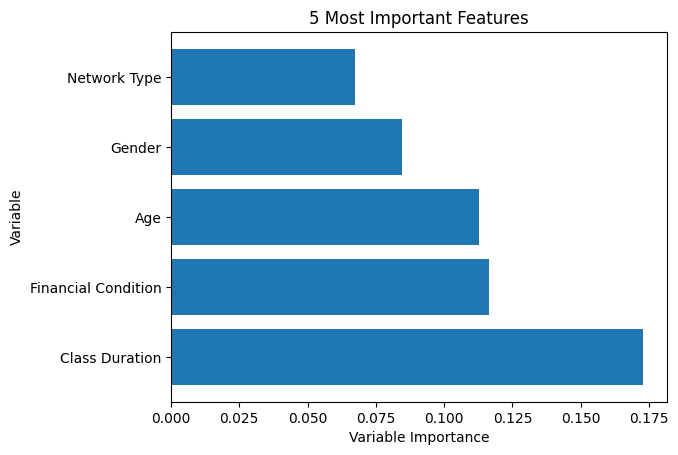

In [44]:
random_forest = RandomForestClassifier()

# Fit the model to your data
random_forest.fit(X_train, y_train)
# Obtain feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Variable': X_train.columns, 'Variable Importance': feature_importances})

# Sort the DataFrame by variable importance in descending order
feature_importances_df = feature_importances_df.sort_values('Variable Importance', ascending=False)

# Display the sorted feature importances
print(feature_importances_df)

# Plot the 5 most important features
top_features = feature_importances_df.nlargest(5, 'Variable Importance')
plt.barh(top_features['Variable'], top_features['Variable Importance'])
plt.title("5 Most Important Features")
plt.xlabel("Variable Importance")
plt.ylabel("Variable")
plt.show()


In [45]:
import joblib

# Train the Random Forest Classifier
random_forest = CONFIG.CLASSIFIERS["RandomForestClassifier"]
random_forest.fit(X_train[CONFIG.FEATURES], y_train)

# Save the trained model to a file
joblib.dump(random_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [46]:
import joblib

# Load the saved model from file
model = joblib.load('random_forest_model.pkl')

# Make predictions on new data
predictions = model.predict(X_test[CONFIG.FEATURES])
